In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../imports/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


## Panel B <br>
Data requirements: patient tissues, PBR matrix, patient mutation matrix

In [2]:
patient_affinities = pd.read_csv(PATH_TO_DATA + 'data/patient_affinities.cancer.PHBR.csv', index_col=0)
patient_mutations = pd.read_csv(PATH_TO_DATA + 'data/patient_mutations.cancer.PHBR.csv', index_col=0)
patient_tissues = pd.read_csv(PATH_TO_DATA + 'data/patient_tissues.csv', index_col=0)

In [3]:
# group mutations by frequency
counts = list(patient_mutations.sum().unique())
mutations_by_count = {}
for count in counts:
    # group all of the mutations with this count in TCGA
    mutations_by_count[count] = list(patient_mutations.sum()[patient_mutations.sum() == count].index)
counts.sort()

In [4]:
# getting the tissue associations for all of the mutations in a particular count
tissues_by_count = {}
for count in counts:
    tissues = []
    for mutation in mutations_by_count[count]:
        patients_with_mutation = list(patient_mutations[patient_mutations[mutation] == 1].index)
        tissues.extend(list(patient_tissues.ix[patients_with_mutation].Tissue))
    tissues_by_count[count] = tissues

In [5]:
all_dfs = []
for count in counts:
    tmp = pd.DataFrame(pd.Series(tissues_by_count[count]).value_counts() / len(tissues_by_count[count])).reset_index()
    tmp.columns = ['tissue', 'frequency']
    tmp['mutation_count'] = count
    all_dfs.append(tmp)
df = pd.concat(all_dfs)

In [6]:
def set_color(x):
    if x[0] <= 0.5:
        return '<=50'
    else:
        return x[1]
df['color'] = df[['frequency', 'tissue']].apply(set_color, axis=1)
counts_to_exclude = list(df[df.frequency > 0.5].mutation_count)

vv Color assignments must be superimposed in illustrator

(0, 1)

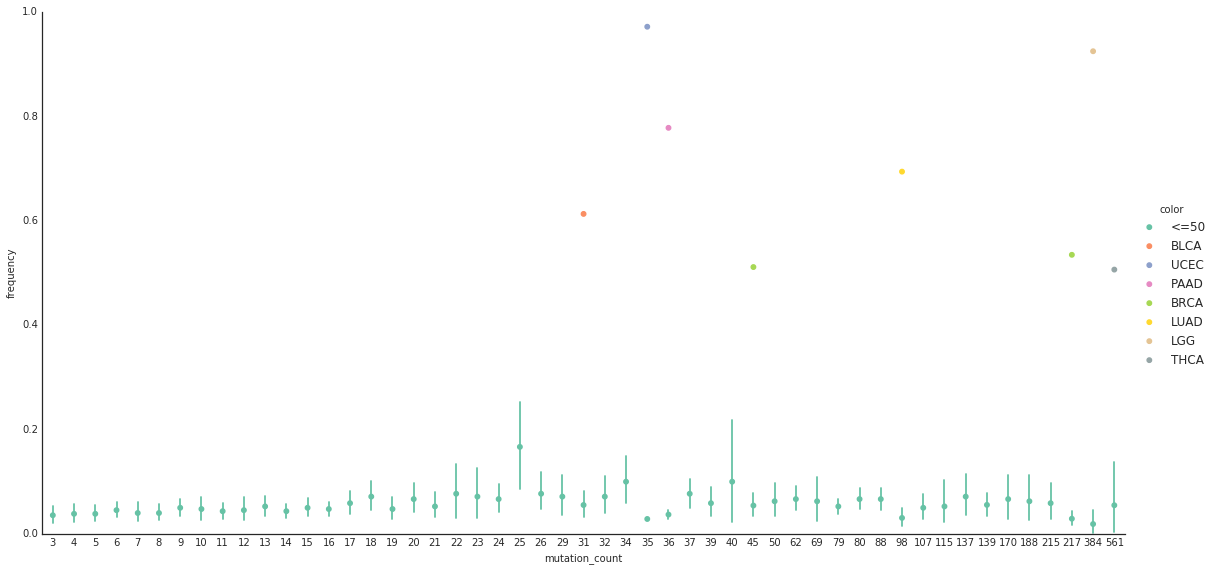

In [7]:
cols = sns.color_palette("Set2", n_colors=7) + sns.color_palette(["#95a5a6"])
sns.factorplot(x='mutation_count', y='frequency', hue='color', data=df, order=counts, size=8, aspect=2, join=False, palette=cols)
plt.ylim(0,1)

(0, 1)

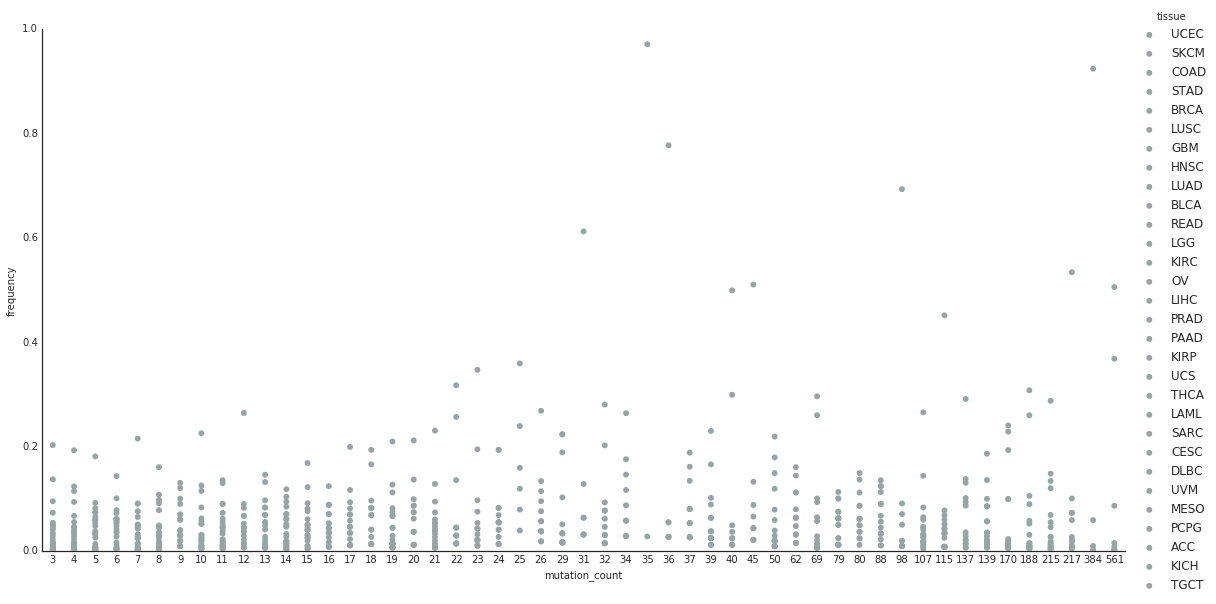

In [8]:
cols = sns.color_palette(["#95a5a6"]*30)
sns.factorplot(x='mutation_count', y='frequency', hue='tissue', data=df, order=counts, size=8, aspect=2, join=False, palette=cols)
plt.ylim(0,1)

Calculating p-value with exclusion

In [9]:
mutation_counts = patient_mutations.sum().reset_index()
mutation_counts.columns = ['mutation', 'count']
mut_counts = sort(mutation_counts['count'].unique())

In [10]:
all_scores, all_mut_counts = [], []
for i, mut_count in enumerate(mut_counts):
    for mutation in list(mutation_counts[mutation_counts['count'] == mut_count].mutation):
        all_scores.extend(list(patient_affinities[mutation]))
        all_mut_counts.extend([mut_count for x in list(patient_affinities[mutation])])
mut_counts_df = pd.DataFrame({'scores': all_scores,
                           'mutation_counts': all_mut_counts})

In [11]:
grouped = mut_counts_df[['mutation_counts', 'scores']].groupby('mutation_counts').median().reset_index()
grouped['index'] = grouped.index
rho, p = sp.spearmanr(grouped[~grouped.mutation_counts.isin(counts_to_exclude)].index, grouped[~grouped.mutation_counts.isin(counts_to_exclude)].scores)[1], sp.spearmanr(grouped[~grouped.mutation_counts.isin(counts_to_exclude)].index, grouped[~grouped.mutation_counts.isin(counts_to_exclude)].scores)[0]

In [12]:
print p, rho

0.497432799758 0.000689504931503
